In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import yaml
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, AutoEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring
import time
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
from graphilp.partitioning import min_vertex_coloring as vtx
from graphilp.imports import networkx as imp_nx

In [ ]:
#q_sampler = AutoEmbeddingComposite(DWaveSampler(token='DEV-076b8a03c140ad9291e859ef02ab3403afc91429'))

#### Generate Network 

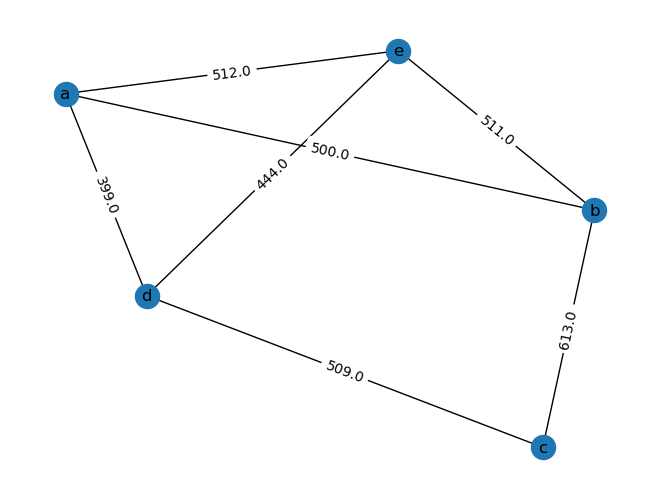

In [2]:
def plot_graph(filename):

    G = nx.read_weighted_edgelist(filename)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()
    return G
G=plot_graph("networks/graph3.txt")

#### Generate Network Demands

In [ ]:
def generate_demands(G):
    demands = {}
    for a in G.nodes:
        for b in G.nodes:
            if b == a:
                pass
            else:
                x = random.randrange(0, 3, 1)
                if x == 0:
                    demands[(a, b)] = 10
                elif x == 1:
                    demands[(a, b)] = 40
                else:
                    demands[(a, b)] = 100
    return demands
demands=generate_demands(G)
print(demands)
#1-demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'e'): 40, ('b', 'f'): 40, ('b', 'c'): 10, ('b', 'd'): 10, ('e', 'f'): 10, ('c', 'e'): 10, ('c', 'f'): 100, ('c', 'd'): 100, ('d', 'e'): 100, ('d', 'f'): 40}
#2-demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'e'): 10, ('b', 'f'): 40, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'f'): 100, ('c', 'e'): 100, ('c', 'f'): 100, ('c', 'd'): 40, ('d', 'e'): 100, ('d', 'f'): 10}
#3-demands={('a', 'b'): 40, ('a', 'e'): 40, ('a', 'f'): 40, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'e'): 100, ('b', 'f'): 100, ('b', 'c'): 10, ('b', 'd'): 10, ('e', 'f'): 10, ('c', 'e'): 10, ('c', 'f'): 40, ('c', 'd'): 10, ('d', 'e'): 10, ('d', 'f'): 100}
#4-demands={('a', 'b'): 40, ('a', 'e'): 100, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'a'): 10, ('b', 'e'): 100, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'a'): 10, ('e', 'b'): 10, ('e', 'c'): 40, ('e', 'd'): 40, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'e'): 100, ('c', 'd'): 40, ('d', 'a'): 10, ('d', 'b'): 40, ('d', 'e'): 10, ('d', 'c'): 10}
#5-demands={('a', 'b'): 40, ('a', 'e'): 40, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'a'): 10, ('b', 'e'): 40, ('b', 'c'): 40, ('b', 'd'): 10, ('e', 'a'): 100, ('e', 'b'): 100, ('e', 'c'): 40, ('e', 'd'): 100, ('c', 'a'): 10, ('c', 'b'): 100, ('c', 'e'): 40, ('c', 'd'): 100, ('d', 'a'): 10, ('d', 'b'): 100, ('d', 'e'): 100, ('d', 'c'): 10}
#demands={('Gdansk', 'Warsaw'): 40, ('Gdansk', 'Kolobrzeg'): 100, ('Gdansk', 'Bydgoszcz'): 100, ('Gdansk', 'Poznan'): 40, ('Gdansk', 'Szczecin'): 100, ('Gdansk', 'Katowice'): 10, ('Gdansk', 'Krakow'): 10, ('Gdansk', 'Lodz'): 40, ('Gdansk', 'Wroclaw'): 10, ('Gdansk', 'Rzeszow'): 10, ('Gdansk', 'Bialystok'): 40, ('Warsaw', 'Gdansk'): 40, ('Warsaw', 'Kolobrzeg'): 100, ('Warsaw', 'Bydgoszcz'): 40, ('Warsaw', 'Poznan'): 100, ('Warsaw', 'Szczecin'): 10, ('Warsaw', 'Katowice'): 40, ('Warsaw', 'Krakow'): 10, ('Warsaw', 'Lodz'): 100, ('Warsaw', 'Wroclaw'): 10, ('Warsaw', 'Rzeszow'): 40, ('Warsaw', 'Bialystok'): 10, ('Kolobrzeg', 'Gdansk'): 10, ('Kolobrzeg', 'Warsaw'): 40, ('Kolobrzeg', 'Bydgoszcz'): 100, ('Kolobrzeg', 'Poznan'): 100, ('Kolobrzeg', 'Szczecin'): 100, ('Kolobrzeg', 'Katowice'): 40, ('Kolobrzeg', 'Krakow'): 100, ('Kolobrzeg', 'Lodz'): 40, ('Kolobrzeg', 'Wroclaw'): 40, ('Kolobrzeg', 'Rzeszow'): 100, ('Kolobrzeg', 'Bialystok'): 10, ('Bydgoszcz', 'Gdansk'): 40, ('Bydgoszcz', 'Warsaw'): 40, ('Bydgoszcz', 'Kolobrzeg'): 100, ('Bydgoszcz', 'Poznan'): 100, ('Bydgoszcz', 'Szczecin'): 40, ('Bydgoszcz', 'Katowice'): 10, ('Bydgoszcz', 'Krakow'): 40, ('Bydgoszcz', 'Lodz'): 100, ('Bydgoszcz', 'Wroclaw'): 40, ('Bydgoszcz', 'Rzeszow'): 100, ('Bydgoszcz', 'Bialystok'): 10, ('Poznan', 'Gdansk'): 10, ('Poznan', 'Warsaw'): 10, ('Poznan', 'Kolobrzeg'): 40, ('Poznan', 'Bydgoszcz'): 10, ('Poznan', 'Szczecin'): 100, ('Poznan', 'Katowice'): 100, ('Poznan', 'Krakow'): 10, ('Poznan', 'Lodz'): 10, ('Poznan', 'Wroclaw'): 40, ('Poznan', 'Rzeszow'): 100, ('Poznan', 'Bialystok'): 100, ('Szczecin', 'Gdansk'): 40, ('Szczecin', 'Warsaw'): 100, ('Szczecin', 'Kolobrzeg'): 10, ('Szczecin', 'Bydgoszcz'): 100, ('Szczecin', 'Poznan'): 100, ('Szczecin', 'Katowice'): 10, ('Szczecin', 'Krakow'): 40, ('Szczecin', 'Lodz'): 40, ('Szczecin', 'Wroclaw'): 100, ('Szczecin', 'Rzeszow'): 40, ('Szczecin', 'Bialystok'): 40, ('Katowice', 'Gdansk'): 40, ('Katowice', 'Warsaw'): 10, ('Katowice', 'Kolobrzeg'): 40, ('Katowice', 'Bydgoszcz'): 40, ('Katowice', 'Poznan'): 100, ('Katowice', 'Szczecin'): 10, ('Katowice', 'Krakow'): 40, ('Katowice', 'Lodz'): 10, ('Katowice', 'Wroclaw'): 100, ('Katowice', 'Rzeszow'): 40, ('Katowice', 'Bialystok'): 100, ('Krakow', 'Gdansk'): 10, ('Krakow', 'Warsaw'): 40, ('Krakow', 'Kolobrzeg'): 10, ('Krakow', 'Bydgoszcz'): 40, ('Krakow', 'Poznan'): 40, ('Krakow', 'Szczecin'): 10, ('Krakow', 'Katowice'): 10, ('Krakow', 'Lodz'): 10, ('Krakow', 'Wroclaw'): 40, ('Krakow', 'Rzeszow'): 40, ('Krakow', 'Bialystok'): 100, ('Lodz', 'Gdansk'): 40, ('Lodz', 'Warsaw'): 10, ('Lodz', 'Kolobrzeg'): 40, ('Lodz', 'Bydgoszcz'): 100, ('Lodz', 'Poznan'): 10, ('Lodz', 'Szczecin'): 100, ('Lodz', 'Katowice'): 100, ('Lodz', 'Krakow'): 10, ('Lodz', 'Wroclaw'): 10, ('Lodz', 'Rzeszow'): 40, ('Lodz', 'Bialystok'): 10, ('Wroclaw', 'Gdansk'): 40, ('Wroclaw', 'Warsaw'): 100, ('Wroclaw', 'Kolobrzeg'): 100, ('Wroclaw', 'Bydgoszcz'): 10, ('Wroclaw', 'Poznan'): 10, ('Wroclaw', 'Szczecin'): 10, ('Wroclaw', 'Katowice'): 100, ('Wroclaw', 'Krakow'): 40, ('Wroclaw', 'Lodz'): 40, ('Wroclaw', 'Rzeszow'): 40, ('Wroclaw', 'Bialystok'): 10, ('Rzeszow', 'Gdansk'): 10, ('Rzeszow', 'Warsaw'): 100, ('Rzeszow', 'Kolobrzeg'): 100, ('Rzeszow', 'Bydgoszcz'): 100, ('Rzeszow', 'Poznan'): 10, ('Rzeszow', 'Szczecin'): 100, ('Rzeszow', 'Katowice'): 10, ('Rzeszow', 'Krakow'): 40, ('Rzeszow', 'Lodz'): 40, ('Rzeszow', 'Wroclaw'): 10, ('Rzeszow', 'Bialystok'): 100, ('Bialystok', 'Gdansk'): 100, ('Bialystok', 'Warsaw'): 100, ('Bialystok', 'Kolobrzeg'): 100, ('Bialystok', 'Bydgoszcz'): 100, ('Bialystok', 'Poznan'): 40, ('Bialystok', 'Szczecin'): 10, ('Bialystok', 'Katowice'): 100, ('Bialystok', 'Krakow'): 10, ('Bialystok', 'Lodz'): 100, ('Bialystok', 'Wroclaw'): 10, ('Bialystok', 'Rzeszow'): 10}


{('a', 'b'): 40, ('a', 'e'): 10, ('a', 'c'): 40, ('a', 'd'): 40, ('b', 'a'): 40, ('b', 'e'): 10, ('b', 'c'): 40, ('b', 'd'): 40, ('e', 'a'): 100, ('e', 'b'): 100, ('e', 'c'): 100, ('e', 'd'): 100, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'e'): 40, ('c', 'd'): 40, ('d', 'a'): 100, ('d', 'b'): 100, ('d', 'e'): 10, ('d', 'c'): 40}


In [ ]:
# Cropped demands only show demands for 1 direction
cropped_demands={}
for item in demands:
    if item[1]>item[0]:
        cropped_demands[item]=demands[item]
print(cropped_demands)

{('Gdansk', 'Warsaw'): 40, ('Gdansk', 'Kolobrzeg'): 100, ('Gdansk', 'Poznan'): 40, ('Gdansk', 'Szczecin'): 100, ('Gdansk', 'Katowice'): 10, ('Gdansk', 'Krakow'): 10, ('Gdansk', 'Lodz'): 40, ('Gdansk', 'Wroclaw'): 10, ('Gdansk', 'Rzeszow'): 10, ('Warsaw', 'Wroclaw'): 10, ('Kolobrzeg', 'Warsaw'): 40, ('Kolobrzeg', 'Poznan'): 100, ('Kolobrzeg', 'Szczecin'): 100, ('Kolobrzeg', 'Krakow'): 100, ('Kolobrzeg', 'Lodz'): 40, ('Kolobrzeg', 'Wroclaw'): 40, ('Kolobrzeg', 'Rzeszow'): 100, ('Bydgoszcz', 'Gdansk'): 40, ('Bydgoszcz', 'Warsaw'): 40, ('Bydgoszcz', 'Kolobrzeg'): 100, ('Bydgoszcz', 'Poznan'): 100, ('Bydgoszcz', 'Szczecin'): 40, ('Bydgoszcz', 'Katowice'): 10, ('Bydgoszcz', 'Krakow'): 40, ('Bydgoszcz', 'Lodz'): 100, ('Bydgoszcz', 'Wroclaw'): 40, ('Bydgoszcz', 'Rzeszow'): 100, ('Poznan', 'Warsaw'): 10, ('Poznan', 'Szczecin'): 100, ('Poznan', 'Wroclaw'): 40, ('Poznan', 'Rzeszow'): 100, ('Szczecin', 'Warsaw'): 100, ('Szczecin', 'Wroclaw'): 100, ('Katowice', 'Warsaw'): 10, ('Katowice', 'Kolobrze

#### Generate graph of routes

46
427


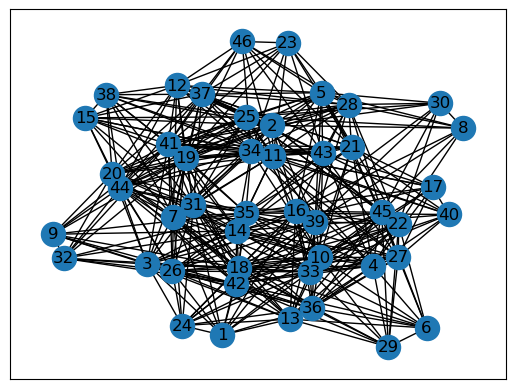

In [ ]:
def create_graph(filepath, Graph, demands):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    converted_graph = nx.Graph()
    s_d_label = 0
    label = 0
    for a in network_data:
        s_d_label += 1
        source = network_data[a]["source"]
        destination = network_data[a]["destination"]
        rate = demands[(source, destination)]
        for i in network_data[a]["routes"]:
            label += 1
            nodes_in_path = i
            edges_in_path = []
            total_weight = 0
            for j in range(len(i) - 1):
                edges_in_path.append((nodes_in_path[j], nodes_in_path[j + 1]))
                edges_in_path.append((nodes_in_path[j+1], nodes_in_path[j])) # remove of direction of light matters.
                total_weight += Graph[nodes_in_path[j]][nodes_in_path[j + 1]]["weight"]
            converted_graph.add_node(label, s_d=s_d_label, r=rate,w=total_weight,edges=edges_in_path)
    x=converted_graph.number_of_nodes()
    for a in range(1,x):
        for b in range(a+1,x+1):
            if converted_graph.nodes[a]["s_d"] != converted_graph.nodes[b]["s_d"]: # don't want edged between same connections - then each one affects the others selection
                for j in converted_graph.nodes[a]["edges"]:
                    for i in converted_graph.nodes[b]["edges"]:
                        if i == j:
                            converted_graph.add_edge(a,b)
                            break
                    else:
                        continue
                    break
                        
                        
    return converted_graph

new_graph=create_graph("networks/graph3-conversion.yaml",G,demands)
nx.draw_networkx(new_graph)
number_of_nodes=len(new_graph.nodes)
print(number_of_nodes)
print(new_graph.number_of_edges())

#### Write QUBO formualtion

In [5]:
def create_qubo(Graph,c1,c2,c3,c4):
    Q={}
    adj_matrix=nx.adjacency_matrix(Graph)
    dense_matrix=adj_matrix.todense()
    set_of_nodes=Graph._node
    for a in set_of_nodes:
        for b in set_of_nodes:
            if Graph.nodes[a]["s_d"]==Graph.nodes[b]["s_d"]:
                if a==b:
                    Q[(a,b)]=-c1
                else:
                    Q[(a,b)]=2*c1
            elif dense_matrix[a-1][b-1]==1:
                Q[(a,b)]=c2
            else:
                Q[(a,b)]=0
    
    for a in set_of_nodes:
        length=Graph.nodes[a]["w"]  
        Q[(a,a)]+=c4*length
        if Graph.nodes[a]["r"]==10:
            max_d=1680
        elif Graph.nodes[a]["r"]==40:
            max_d=1170
        else:
            max_d=1060
        if length>max_d:
            Q[(a,a)]+=c3


    return Q
            
QUBO = create_qubo(new_graph,4,0,4,0)
bqm= BinaryQuadraticModel.from_qubo(QUBO)

#### Solve with Gurobi  

In [10]:
def solve_qubo_with_gurobi(Q,time_limit=1000):
    # Create a Gurobi model
    model = Model("QUBO")

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)
    
    # Set a time limit (in seconds)
    model.setParam('TimeLimit', time_limit)

    # Extract variables from QUBO keys
    variables = set(i for i, j in Q.keys()).union(set(j for i, j in Q.keys()))

    # Add binary variables to the model
    x = {v: model.addVar(vtype=GRB.BINARY, name=f'x_{v}') for v in variables}

    # Add the QUBO objective function
    model.setObjective(
        quicksum(Q[i, j] * x[i] * x[j] for i, j in Q.keys()),
        GRB.MINIMIZE
    )
    # Measure the runtime
    start_time = time.time()
    model.optimize()
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time


    # Extract the solution
    if model.status == GRB.OPTIMAL:
        solution = {v: int(x[v].x) for v in variables}
        objective_value = model.objVal
        return solution, objective_value,runtime
    else:
        return None, None

QUBO = create_qubo(new_graph,4.5,0.17,4.5,0.0003)

gurobi_sol=solve_qubo_with_gurobi(QUBO)
print(gurobi_sol)

({1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 1, 16: 0, 17: 1, 18: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 1, 24: 1, 25: 0, 26: 0, 27: 1, 28: 0, 29: 1, 30: 1, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 1, 37: 0, 38: 1, 39: 0, 40: 1, 41: 0, 42: 0, 43: 0, 44: 1, 45: 0, 46: 1}, -73.26310000000001, 0.401256799697876)


In [ ]:
gurobi_table=[]
# Produce Gurobi output as a list
for i in range(1,number_of_nodes+1):
    gurobi_table.append(gurobi_sol[0][i])
print(gurobi_table)


[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]


#### Solve with QA/SA 

In [11]:
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm)
print(result)
for variable in range(1,number_of_nodes+1):
    print(int(result.first.sample[variable]))

   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 ... 924 energy num_oc.
0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 ...   0 -528.0       1
['BINARY', 1 rows, 1 samples, 924 variables]
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0

#### Check if solution is valid

In [ ]:
def is_valid_solution(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=[]
    total_length=0
    for i in range(1,number_of_nodes+1):
        solution_results.append(int(result.first.sample[i]))
        if int(result.first.sample[i])==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]

def is_valid_solution_gurobi(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=result
    total_length=0
    for i in range(1,number_of_routes[-1]+1):
        if solution_results[i-1]==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]
    
print(is_valid_solution(result,"networks/poland-conversion2.yaml",new_graph))
#print(is_valid_solution_gurobi(gurobi_table,"networks/poland-conversion.yaml",new_graph))


[True, 101524.3]


#### Is solution same as Gurobi solution

In [24]:
solution_values=[]
for variable in range(1,number_of_nodes+1):
    solution_values.append(int(result.first.sample[variable]))
print(solution_values==gurobi_table)
for variable in range(1,number_of_nodes+1):
    if not solution_values[variable-1]==gurobi_table[variable-1]:
        print(variable)

False
1
2
10
12
17
20
25
27
30
31
47
48
58
60
69
70
72
76
80
82
86
87
94
96
100
104
113
114
122
123
128
130
135
139
141
146
148
149
159
160
166
167
171
175
184
188
191
196
204
206
215
216
219
220
226
230
233
234
246
247
253
258
268
270
274
279
300
301
303
308
317
318
324
329
333
335
340
342
345
347
356
357
358
359
365
366
373
374
380
384
386
387
395
398
417
418
426
427
429
431
445
447
459
460


#### Generate reduced graph

20


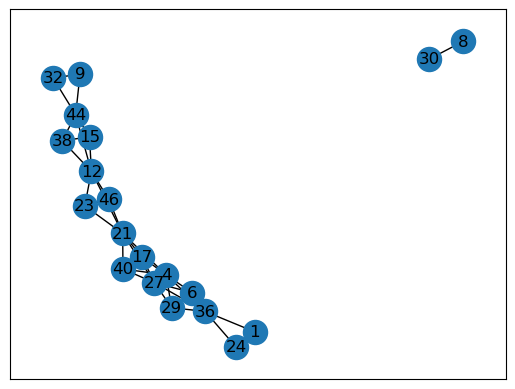

In [ ]:
reduced_graph=create_graph("networks/graph3-conversion.yaml",G,demands)
for i in range(number_of_nodes):
    if gurobi_table[i]==0:
        reduced_graph.remove_node(i+1)

pos = nx.spring_layout(G, k=100, iterations=100)
nx.draw_networkx(reduced_graph)
print(reduced_graph.number_of_nodes())

### Graph Colouring Gurobi

In [ ]:
def solve_graph_coloring_gurobi(Graph):
    edges = list(Graph.edges)
    G = imp_nx.read(Graph)
    # List of edges (each edge represented as a tuple of nodes)
    

    # Create a Gurobi environment with output suppressed
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)  # Suppress output
    env.start()
    
    # Create the model using vtx.create_model
    mdl = vtx.create_model(G)

    # Optimize the model
    start_time = time.time()
    mdl.optimize()
    end_time = time.time()

    # Extract the solution using the provided function
    color_to_node, node_to_color = vtx.extract_solution(G, mdl)

    if mdl.status == GRB.OPTIMAL:
        # Use the extracted solution to build the color_map
        color_map = {node: color for color, nodes in color_to_node.items() for node in nodes}
        used_colors = set(color_map.values())

        # Verify that no two adjacent nodes have the same color
        valid = True
        for (i, j) in edges:
            if color_map[i] == color_map[j]:
                valid = False
                break  # No need to continue if an invalid pair is found

        return {
            "valid": valid,
            "num_colors": len(used_colors),
            "time_taken": end_time - start_time
        }
    else:
        return {
            "valid": False,
            "num_colors": None,
            "time_taken": end_time - start_time
        }

solve_graph_coloring_gurobi(reduced_graph)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 3 4300U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

### LDF Greedy

In [ ]:
def solve_graph_coloring_networkx(G):
    start_time = time.time()
    nx_coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    end_time = time.time()

    nx_colors_used = len(set(nx_coloring.values()))

    return {
        "valid": True,  # Greedy algorithm should provide a valid coloring
        "num_colors": nx_colors_used,
        "time_taken": end_time - start_time,
        "coloring": nx_coloring
    }
 
colouring=solve_graph_coloring_networkx(reduced_graph)
print(colouring)

{'valid': True, 'num_colors': 156, 'time_taken': 0.17827415466308594, 'coloring': {371: 0, 833: 1, 238: 2, 700: 3, 391: 4, 595: 5, 853: 6, 83: 7, 419: 8, 545: 9, 881: 10, 133: 11, 420: 8, 882: 10, 377: 12, 839: 13, 378: 12, 840: 13, 293: 14, 389: 4, 755: 15, 851: 6, 451: 16, 913: 17, 286: 18, 748: 19, 358: 20, 820: 21, 14: 22, 415: 8, 476: 23, 877: 10, 107: 24, 569: 25, 214: 26, 250: 27, 350: 28, 676: 29, 712: 30, 812: 31, 131: 11, 327: 32, 455: 16, 593: 5, 789: 33, 917: 17, 129: 11, 143: 34, 262: 35, 363: 20, 591: 5, 605: 36, 724: 37, 825: 21, 84: 7, 546: 9, 118: 38, 251: 27, 458: 39, 580: 40, 713: 30, 920: 41, 404: 42, 866: 43, 292: 14, 418: 8, 754: 15, 880: 10, 272: 44, 355: 45, 397: 46, 734: 47, 817: 48, 859: 49, 367: 0, 829: 1, 34: 50, 496: 51, 594: 5, 90: 52, 132: 11, 552: 53, 147: 34, 243: 54, 609: 36, 705: 55, 86: 52, 232: 2, 548: 53, 694: 3, 63: 56, 525: 57, 81: 7, 543: 9, 6: 58, 236: 2, 376: 12, 468: 59, 698: 3, 838: 13, 213: 26, 675: 29, 116: 38, 402: 42, 578: 40, 864: 43, 4

#### QA to find colouring of generated graph

In [ ]:
def solve_graph_coloring_annealing(G, sampler, attempts=30):
    start_time = time.time()
    for i in range(attempts):        
        solution = min_vertex_color(G, sampler=sampler, label="GCP")
        try:
            if is_vertex_coloring(G, solution):
                end_time = time.time()
                wavelengths = len(set(solution.values()))
                return {
                    "valid": True,
                    "num_colors": wavelengths,
                    "time_taken": end_time - start_time,
                    "solution": solution
                }
            print(f"[-] Attempt {i} failed")
        except KeyError:
            continue
    return "timeout"
colouring=solve_graph_coloring_annealing(reduced_graph,SimulatedAnnealingSampler())
print(colouring)

{'valid': True, 'num_colors': 16, 'time_taken': 0.2664196491241455, 'solution': {2: 9, 8: 4, 15: 2, 23: 3, 30: 1, 38: 6, 43: 1, 50: 1, 57: 2, 64: 12, 75: 7, 78: 4, 91: 8, 97: 2, 99: 14, 108: 8, 113: 2, 125: 1, 128: 9, 134: 10, 145: 11, 154: 10, 156: 6, 162: 8, 170: 3, 177: 16, 183: 9, 190: 6, 198: 13, 207: 1, 211: 9, 219: 4, 225: 0, 234: 11, 239: 4, 252: 5, 254: 9, 261: 10, 267: 7, 274: 5, 282: 4, 288: 8, 296: 10, 302: 9, 309: 12, 317: 8, 324: 12, 330: 10, 337: 0, 344: 0, 354: 7, 359: 14, 366: 5, 374: 2, 379: 0, 386: 0, 398: 13, 400: 10, 407: 0, 414: 0, 421: 3, 428: 0, 435: 3, 442: 5, 449: 6, 457: 7}}


#### Generate graph of colouring of reduced graph

13


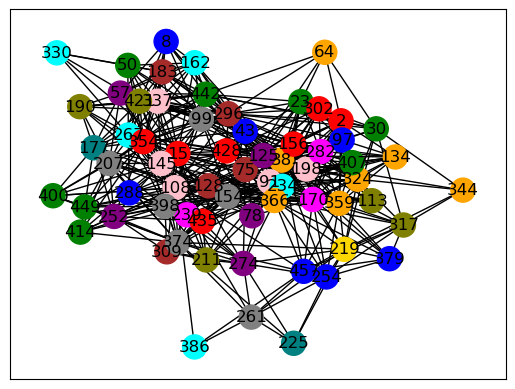

In [ ]:
selected_colours=colouring["coloring"]
# extend following list if more colours are required.
colours = [
    "red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan",
    "magenta", "teal", "gold", "navy", "lime", "maroon", "coral", "turquoise", "indigo", "salmon",
    "darkgreen", "deepskyblue", "chocolate", "orchid", "slateblue", "darkorange", "skyblue", "firebrick", "mediumseagreen", "dodgerblue",
    "plum", "lightcoral", "mediumvioletred", "sienna", "khaki", "darkcyan", "steelblue", "crimson", "darkorchid", "mediumturquoise"
]
color_map=[]
for a in selected_colours:
    color_map.append(colours[selected_colours[a]])
print(colouring["num_colors"])
pos = nx.spring_layout(G, k=100, iterations=100)
nx.draw_networkx(reduced_graph,node_color=color_map)

#### Brute force parameter search

In [ ]:
solve_rate=[]
min_colouring=[]
total_lengths=[]
for i in range(0,10):
    QUBO = create_qubo(new_graph,5,0.005*i,5,0)
    bqm= BinaryQuadraticModel.from_qubo(QUBO)
    #correct_solution=gurobi_table
    runs=1
    solved_cases=0
    time_taken=0
    colour_dic_SA={}
    for i in range(runs):
        start=time.perf_counter()
        solution=solve_qubo(bqm)
        end=time.perf_counter()
        time_taken+=(end-start)
        solution_outcomes=[]
        for variable in range(1,number_of_nodes+1):
            solution_outcomes.append(solution.first.sample[variable])
        if is_valid_solution(solution,"networks/poland-conversion.yaml",new_graph)[0]:
            solved_cases+=1
            graph=new_graph.copy()
            total_length=0
            for i in range(number_of_nodes-1):
                if solution_outcomes[i]==0:
                    graph.remove_node(i+1)
                else:
                    total_length+=new_graph.nodes[i+1]["w"]
            coloured=solve_graph_coloring_networkx(graph)
            if coloured["num_colors"] in colour_dic_SA:
                colour_dic_SA[coloured["num_colors"]]+=1
            else:
                colour_dic_SA[coloured["num_colors"]]=1
    solve_rate.append(solved_cases/runs)
    if colour_dic_SA=={}:
        min_colouring.append(500)
    else:
        min_colouring.append(min(colour_dic_SA.keys()))
    total_lengths.append(total_length)
    

print(solve_rate)
print(min_colouring)
print(total_lengths)


#### SA/QA accuracy test

In [ ]:
QUBO = create_qubo(new_graph,5,0.045,5,0)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
#correct_solution=gurobi_table
runs=200
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic_SA={}
colour_dic_lengths_SA={}
best_solution=None
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/poland-conversion.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        total_length=0
        for k in range(number_of_nodes-1):
            if solution_outcomes[k]==0:
                graph.remove_node(k+1)
            else:
                total_length+=new_graph.nodes[k+1]["w"]
        coloured=solve_graph_coloring_networkx(graph)
        if best_solution is None:
            best_solution=[coloured,total_length,solution]
        elif coloured["num_colors"] < best_solution[0]["num_colors"]:
            best_solution=[coloured,total_length,solution]
        elif coloured["num_colors"] == best_solution[0]["num_colors"]:
            if total_length < best_solution[1]:
                best_solution=[coloured,total_length,solution]
        if coloured["num_colors"] in colour_dic_lengths_SA:
            colour_dic_lengths_SA[coloured["num_colors"]].append(total_length)
        else:
            colour_dic_lengths_SA[coloured["num_colors"]]=[total_length]
        if coloured["num_colors"] in colour_dic_SA:
            colour_dic_SA[coloured["num_colors"]]+=1
        else:
            colour_dic_SA[coloured["num_colors"]]=1
    #if solution_outcomes==correct_solution:
        # optimal_solves+=1
    

print(solved_cases/runs,optimal_solves/runs,time_taken/runs,colour_dic_SA) 
print(best_solution[0]["num_colors"],best_solution[1],best_solution[2])